<a href="https://colab.research.google.com/github/Jayavathsan/MachineLearning/blob/main/4_Time_Series_Forecasting_with_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series Forecasting with ARIMA using Yahoo API and Google stock price

To use Yahoo finance API install yahoo finance using command"pip install yfinance"

In [1]:
!pip install yfinance

import necessary libraries

In [2]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Collect Google's stock price

In [3]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# view last five entries of the dataset
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-02-06  145.960007  146.740005  144.520004  145.410004  145.410004   
247 2024-02-07  146.119995  147.000000  145.210007  146.679993  146.679993   
248 2024-02-08  146.970001  147.610001  146.419998  147.220001  147.220001   
249 2024-02-09  147.949997  150.695007  147.429993  150.220001  150.220001   
250 2024-02-12  149.539993  150.589996  148.559998  148.729996  148.729996   

       Volume  
246  21517700  
247  21436100  
248  18241300  
249  21864000  
250  17220700  


In [4]:
# move date and close price columns further for more convinience
data = data[["Date", "Close"]]
print(data.head())

        Date      Close
0 2023-02-13  95.000000
1 2023-02-14  94.949997
2 2023-02-15  97.099998
3 2023-02-16  95.779999
4 2023-02-17  94.589996


Visualize close prices of Google

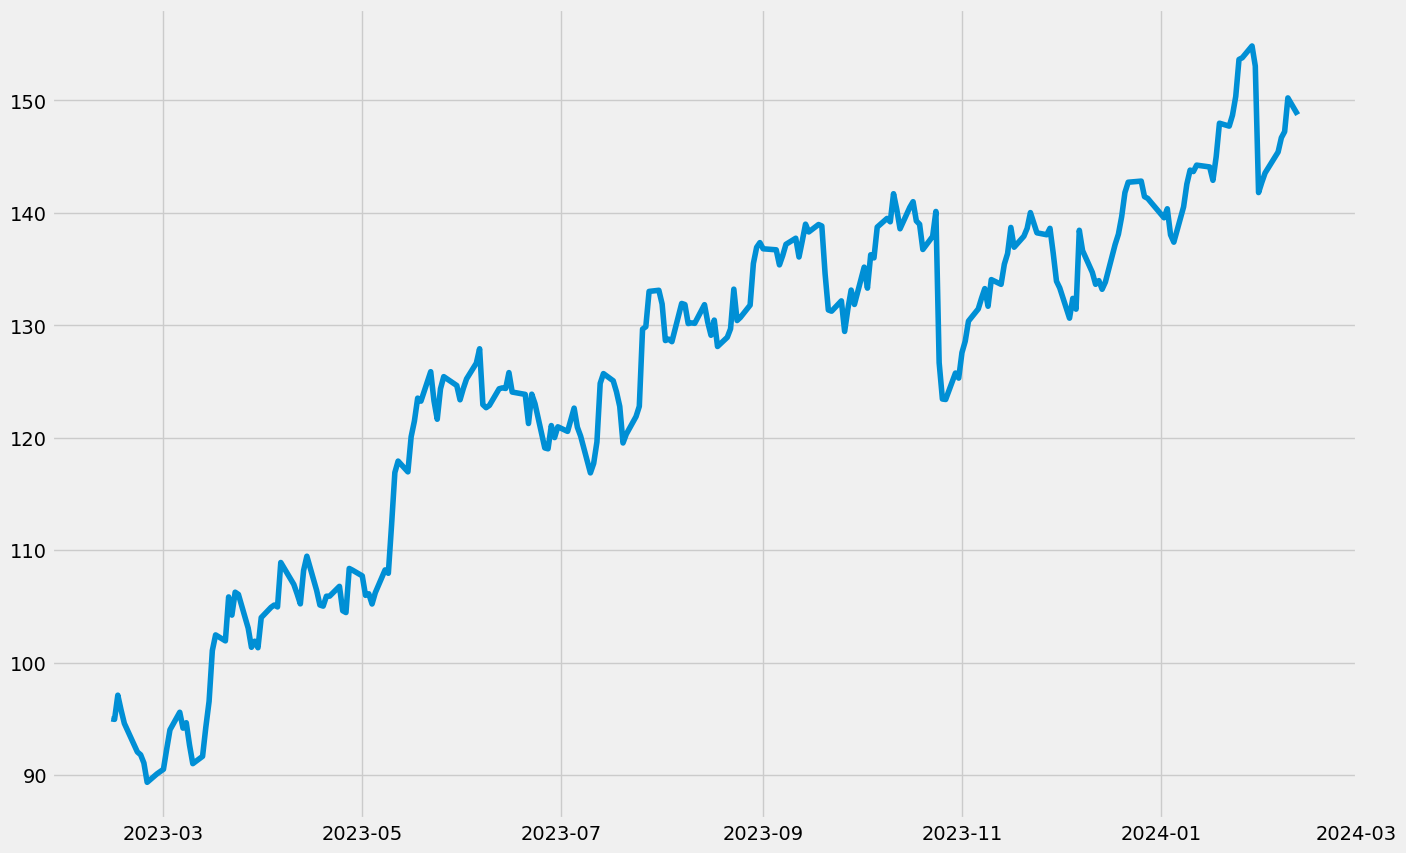

In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))
plt.plot(data["Date"], data["Close"])

Before using the ARIMA model seasonal decomposition method is used to split tje time series into trend, seasonal and residuals for better understanding of the data

<Figure size 640x480 with 0 Axes>

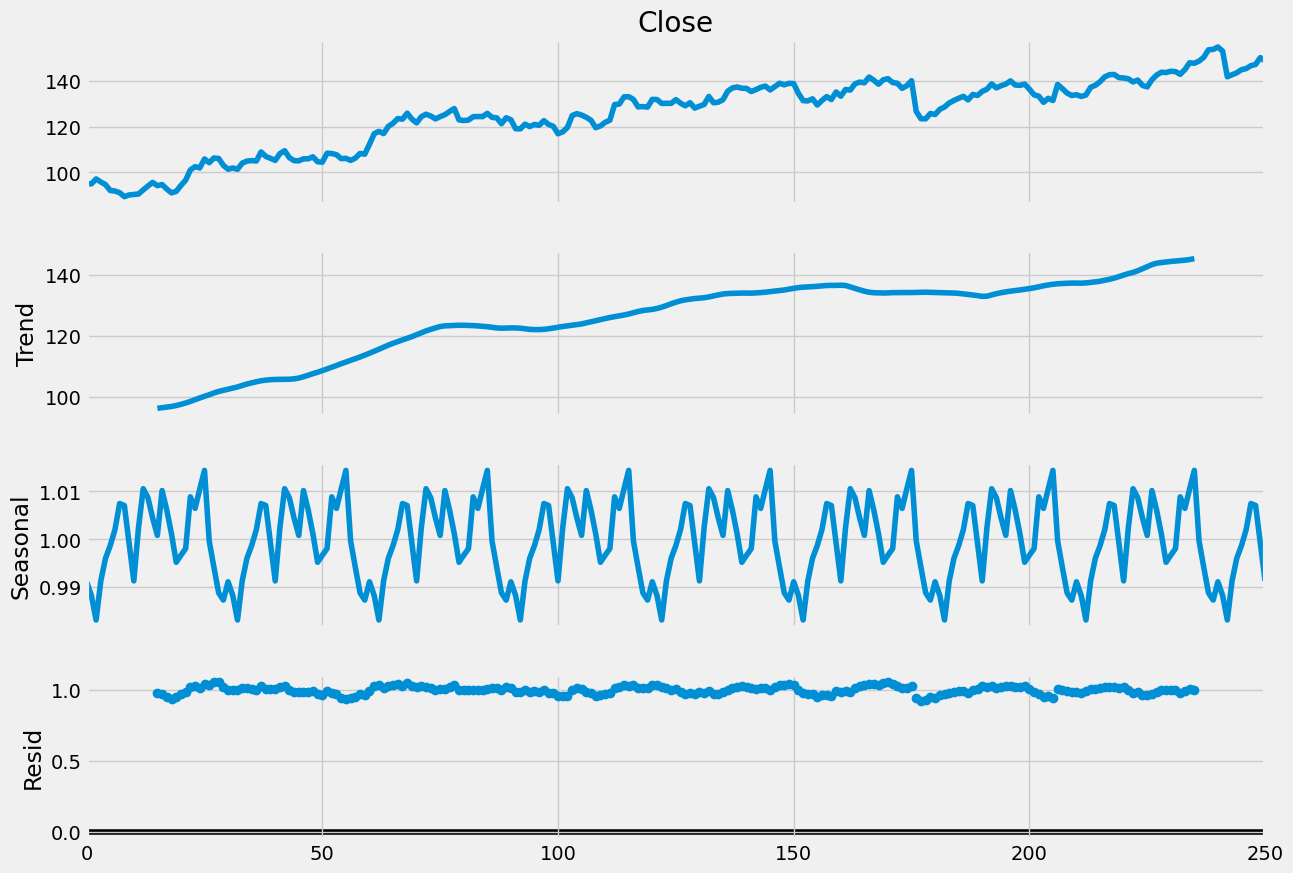

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],
                            model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

The data is seasonal. Seasonal ARIMA model is to be used for forecasting on this data.

to use ARIMA or Seasonal ARIMA model, p, d and q values are needed.

Since the data is seasonal d value is 1. (if stationary d value would be 0)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

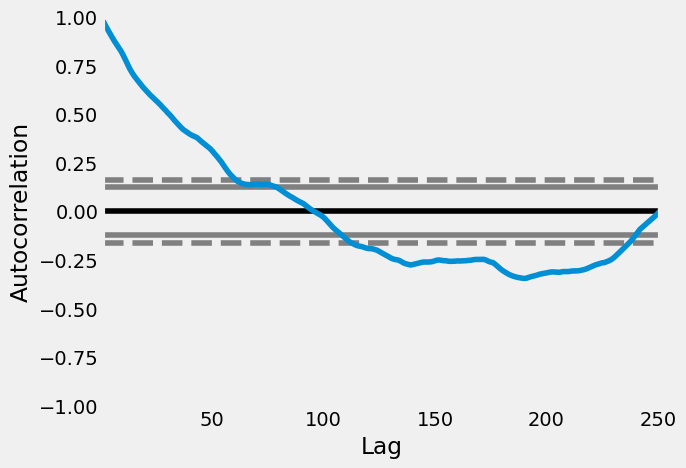

In [8]:
# to find value of p:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary.

Hence the value of p is 5.

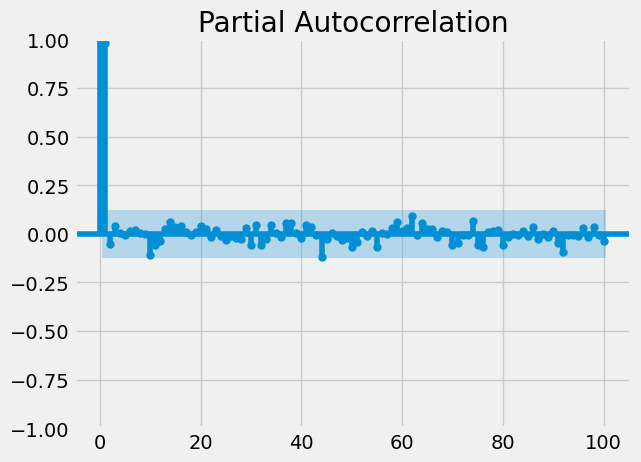

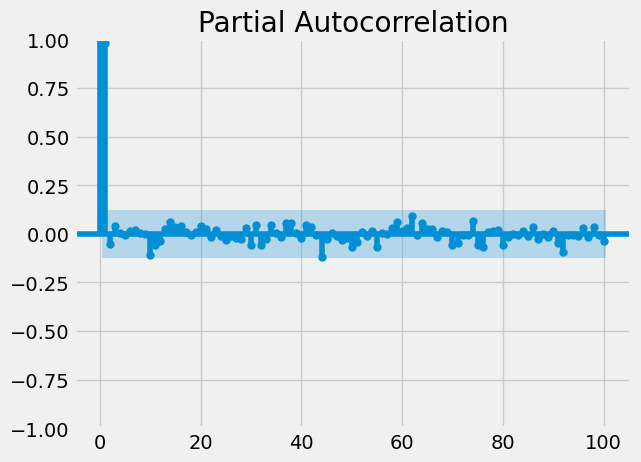

In [9]:
# finding q (moving average)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

According to the above partial autocorrelation plot, only two points are far away from all the points.

Hence the value of q is 2

In [11]:
!pip install statsmodels

In [16]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))

In [18]:
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -547.734
Date:                Tue, 13 Feb 2024   AIC                           1111.467
Time:                        12:13:26   BIC                           1139.639
Sample:                             0   HQIC                          1122.806
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2990      0.102     12.674      0.000       1.098       1.500
ar.L2         -0.9729      0.141     -6.923      0.000      -1.248      -0.698
ar.L3         -0.0142      0.146     -0.097      0.9

Predict the values using ARIMA model

In [19]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1       95.000027
2       94.947089
3       97.224913
4       95.715018
          ...    
246    144.694889
247    145.693904
248    147.244065
249    147.664603
250    150.229760
Name: predicted_mean, Length: 251, dtype: float64


Since the data is seasonal, ARIMA model has produced wrong data.

SARIMA model would yield better results.

In [20]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -535.646
Date:                            Tue, 13 Feb 2024   AIC                           1101.292
Time:                                    12:18:54   BIC                           1153.376
Sample:                                         0   HQIC                          1122.283
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2511      0.314      3.984      0.000       0.636       1.867
ar.L2         -0.7169      0.291   

Predict prices for next 10 days using the SARIMA model

In [21]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

251    147.832194
252    147.196391
253    147.486783
254    147.796671
255    148.489171
256    149.432202
257    150.837584
258    152.089925
259    151.674890
260    151.036895
261    150.045171
Name: predicted_mean, dtype: float64


Plotting the predictions

<Axes: >

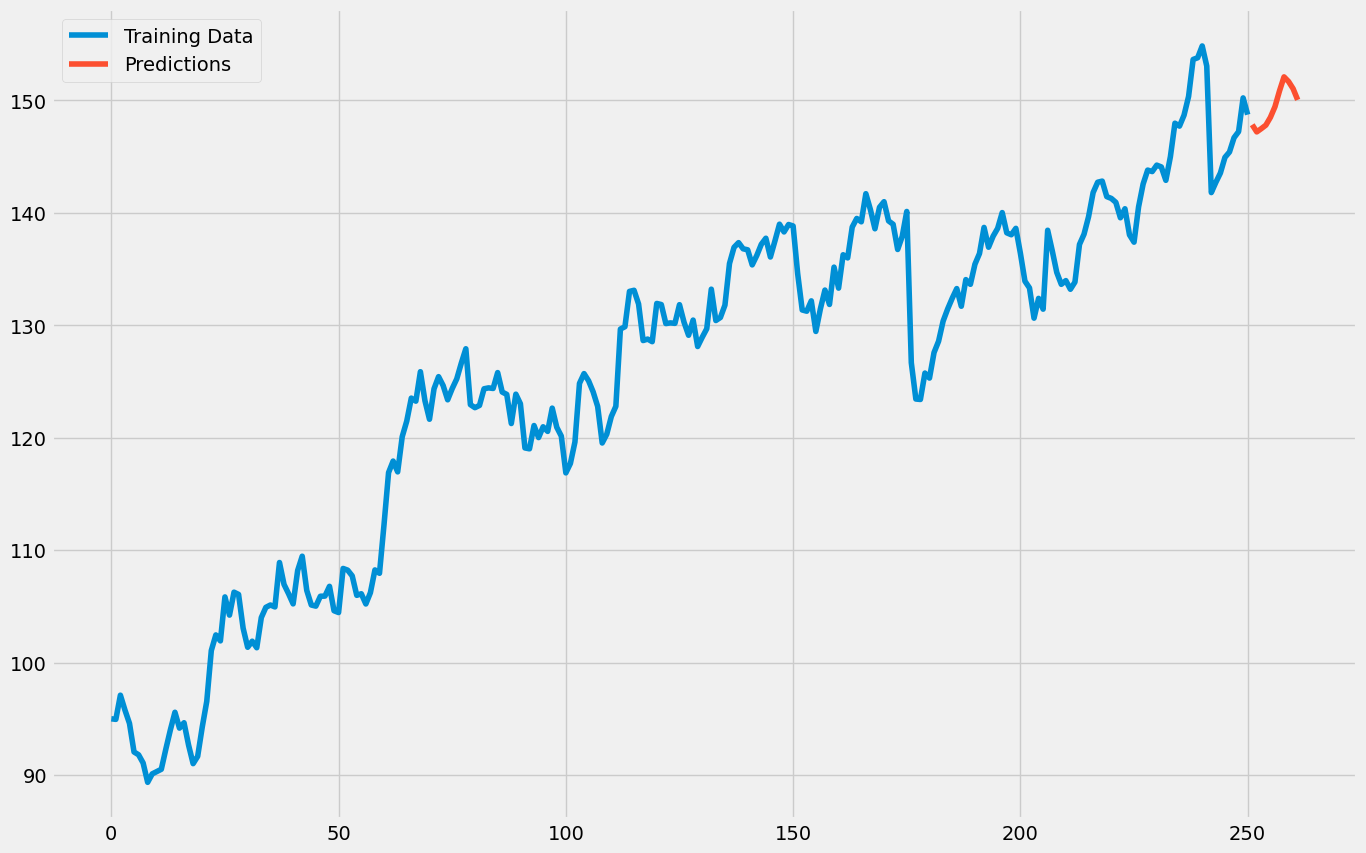

In [22]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")